# E-commerce Customer Segmentation

## Customer file Notebook

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Table of Content</h3>

* [1. Problematic](#1)
* [2. Methodology](#2)    
* [3. Data preparation](#3)
  - [3.1 Importing libraries](#3.1)
  - [3.2 Importing Data into DataFrame](#3.2)
* [4. Exploratory Analysis](#4)
  - [4.1 Data Overview](#4.1)
  - [4.2 Data Distribution](#4.2)
  - [4.3 SQL Queries](#4.3)
* [5. Features Engineering](#5)
  - [5.1 RFM Analysis](#5.1)
  - [5.2 Improved Features](#5.2)
  - [5.3 Data Transformation](#5.3)
* [6. Conclusion](#6)

<a id="1"></a>
<font color="darkslateblue" size=+2.5><b>1. Problematic</b></font>

##### Project mission: Segment customers in odrer to implement better targeted communication campaigns.

Specifications :
- Actionable description of a segmentation and its underlying logic for optimal use
- Maintenance contract proposal based on an analysis of the stability of the segments over time.
- Code in PEP8 format


Creation in this notebook of a customer file where the data is aggregated by single customer in order to create a clustering of customer profiles.

<a id="2"></a>
<font color="darkslateblue" size=+2.5><b>2. Methodology</b></font>

- We recover the database in DB format

- then carry out a quick exploratory analysis in SQL followed by one in Python in order to better understand how to aggregate the data

- next we realise a feature engineering on the RFM variables : Recency, Frequency, Monetary

- followed by a feature engineering on three other variables: customer satisfaction, payment terms, type of order with the number of items.

- finally we transform the data with logarithm transformation and a standardScalerin order to use it for clustering.

<a id="3"></a>
<font color="darkslateblue" size=+2.5><b>3. Data preparation</b></font>

<a id="3.1"></a>
<font color="dimgrey" size=+2.0><b>3.1 Importing libraries</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:dimgrey" data-toggle="popover">go to TOC</a>

In [1]:
import sqlite3

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt 
import seaborn as sns

from matplotlib.gridspec import GridSpec

import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl

from P5_functions import *

In [2]:
cnx = sqlite3.connect('olist.db')

In [4]:
curs = cnx.cursor()

In [5]:
curs.execute("SELECT name FROM sqlite_master WHERE type = 'table'").fetchall()

[('customers',),
 ('geoloc',),
 ('order_items',),
 ('order_pymts',),
 ('order_reviews',),
 ('orders',),
 ('products',),
 ('sellers',),
 ('translation',)]

<a id="3.2"></a>
<font color="dimgrey" size=+2.0><b>3.2 Importing data into DataFrame</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:dimgrey" data-toggle="popover">go to TOC</a>

In [6]:
# Chargement des données 
customers_df = pd.read_sql_query('select * from customers', cnx).drop('index',axis = 1)
geo_df = pd.read_sql_query('select * from geoloc', cnx).drop('index',axis = 1)
orderitem_df = pd.read_sql_query('select * from order_items', cnx).drop('index',axis = 1)
orderpay_df = pd.read_sql_query('select * from order_pymts', cnx).drop('index',axis = 1)
orderreviews_df = pd.read_sql_query('select * from order_reviews', cnx).drop('index',axis = 1) 
orders_df = pd.read_sql_query('select * from orders', cnx).drop('index',axis = 1) 
products_df = pd.read_sql_query('select * from products', cnx).drop('index',axis = 1) 
sellers_df = pd.read_sql_query('select * from sellers', cnx).drop('index',axis = 1) 
categname_df = pd.read_sql_query('select * from translation', cnx).drop('index',axis = 1) 
# Change cols names before merging 
customers_df.rename(columns={"customer_zip_code_prefix": "zip_code"}, inplace=True)
geo_df.rename(columns={"geolocation_zip_code_prefix": "zip_code"}, inplace=True)

![image](https://i.imgur.com/HRhd2Y0.png)

<a id="4"></a>
<font color="darkslateblue" size=+2.5><b>4. Exploratory Analysis</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:grey" data-toggle="popover">go to TOC</a>

<a id="4.1"></a>
<font color="dimgrey" size=+2.0><b>4.1 Data Overview</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:dimgrey" data-toggle="popover">go to TOC</a>

In [7]:
for row in curs.execute("PRAGMA table_info(customers)"):
    print(row)

(0, 'index', 'BIGINT', 0, None, 0)
(1, 'customer_id', 'TEXT', 0, None, 0)
(2, 'customer_unique_id', 'TEXT', 0, None, 0)
(3, 'customer_zip_code_prefix', 'BIGINT', 0, None, 0)
(4, 'customer_city', 'TEXT', 0, None, 0)
(5, 'customer_state', 'TEXT', 0, None, 0)


In [8]:
for row in curs.execute("PRAGMA table_info(geoloc)"):
    print(row)

(0, 'index', 'BIGINT', 0, None, 0)
(1, 'geolocation_zip_code_prefix', 'BIGINT', 0, None, 0)
(2, 'geolocation_lat', 'FLOAT', 0, None, 0)
(3, 'geolocation_lng', 'FLOAT', 0, None, 0)
(4, 'geolocation_city', 'TEXT', 0, None, 0)
(5, 'geolocation_state', 'TEXT', 0, None, 0)


In [9]:
for row in curs.execute("PRAGMA table_info(order_items)"):
    print(row)

(0, 'index', 'BIGINT', 0, None, 0)
(1, 'order_id', 'TEXT', 0, None, 0)
(2, 'order_item_id', 'BIGINT', 0, None, 0)
(3, 'product_id', 'TEXT', 0, None, 0)
(4, 'seller_id', 'TEXT', 0, None, 0)
(5, 'shipping_limit_date', 'TEXT', 0, None, 0)
(6, 'price', 'FLOAT', 0, None, 0)
(7, 'freight_value', 'FLOAT', 0, None, 0)


In [10]:
for row in curs.execute("PRAGMA table_info(order_pymts)"):
    print(row)

(0, 'index', 'BIGINT', 0, None, 0)
(1, 'order_id', 'TEXT', 0, None, 0)
(2, 'payment_sequential', 'BIGINT', 0, None, 0)
(3, 'payment_type', 'TEXT', 0, None, 0)
(4, 'payment_installments', 'BIGINT', 0, None, 0)
(5, 'payment_value', 'FLOAT', 0, None, 0)


In [11]:
for row in curs.execute("PRAGMA table_info(order_reviews)"):
    print(row)

(0, 'index', 'BIGINT', 0, None, 0)
(1, 'review_id', 'TEXT', 0, None, 0)
(2, 'order_id', 'TEXT', 0, None, 0)
(3, 'review_score', 'BIGINT', 0, None, 0)
(4, 'review_comment_title', 'TEXT', 0, None, 0)
(5, 'review_comment_message', 'TEXT', 0, None, 0)
(6, 'review_creation_date', 'TEXT', 0, None, 0)
(7, 'review_answer_timestamp', 'TEXT', 0, None, 0)


In [12]:
for row in curs.execute("PRAGMA table_info(orders)"):
    print(row)

(0, 'index', 'BIGINT', 0, None, 0)
(1, 'order_id', 'TEXT', 0, None, 0)
(2, 'customer_id', 'TEXT', 0, None, 0)
(3, 'order_status', 'TEXT', 0, None, 0)
(4, 'order_purchase_timestamp', 'TEXT', 0, None, 0)
(5, 'order_approved_at', 'TEXT', 0, None, 0)
(6, 'order_delivered_carrier_date', 'TEXT', 0, None, 0)
(7, 'order_delivered_customer_date', 'TEXT', 0, None, 0)
(8, 'order_estimated_delivery_date', 'TEXT', 0, None, 0)


In [13]:
for row in curs.execute("PRAGMA table_info(products)"):
    print(row)

(0, 'index', 'BIGINT', 0, None, 0)
(1, 'product_id', 'TEXT', 0, None, 0)
(2, 'product_category_name', 'TEXT', 0, None, 0)
(3, 'product_name_lenght', 'FLOAT', 0, None, 0)
(4, 'product_description_lenght', 'FLOAT', 0, None, 0)
(5, 'product_photos_qty', 'FLOAT', 0, None, 0)
(6, 'product_weight_g', 'FLOAT', 0, None, 0)
(7, 'product_length_cm', 'FLOAT', 0, None, 0)
(8, 'product_height_cm', 'FLOAT', 0, None, 0)
(9, 'product_width_cm', 'FLOAT', 0, None, 0)


In [14]:
for row in curs.execute("PRAGMA table_info(sellers)"):
    print(row)

(0, 'index', 'BIGINT', 0, None, 0)
(1, 'seller_id', 'TEXT', 0, None, 0)
(2, 'seller_zip_code_prefix', 'BIGINT', 0, None, 0)
(3, 'seller_city', 'TEXT', 0, None, 0)
(4, 'seller_state', 'TEXT', 0, None, 0)


In [15]:
for row in curs.execute("PRAGMA table_info(translation)"):
    print(row)

(0, 'index', 'BIGINT', 0, None, 0)
(1, 'product_category_name', 'TEXT', 0, None, 0)
(2, 'product_category_name_english', 'TEXT', 0, None, 0)


In [16]:
# General description

Before creating a unique dataset with all useful information, let's look at the shape of each dataset, so we can be more assertive on how to use joining statements.

In [17]:
# Collections for each dataset
datasets = [customers_df, geo_df, orders_df, orderitem_df, orderpay_df,
            orderreviews_df, products_df, sellers_df]
names = ['customers_df', 'geo_df', 'orders_df', 'orderitem_df', 'orderpay_df',
         'orderreviews_df', 'products_df', 'sellers_df']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_amount,qty_null_columns,null_columns
0,customers_df,99441,5,0,0,
1,geo_df,1000163,5,0,0,
2,orders_df,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,orderitem_df,112650,7,0,0,
4,orderpay_df,103886,5,0,0,
5,orderreviews_df,99224,7,145903,2,"review_comment_title, review_comment_message"
6,products_df,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,sellers_df,3095,4,0,0,


In [18]:
df_overview = pd.DataFrame({})
name_col = []
for name, df in zip(names, datasets):
    name_col += [name] * df.shape[1]
    df_overview = df_overview._append(data_overview(df))
    df_overview['dataset_name'] = name_col

df_overview = df_overview.loc[:, ['dataset_name', 'feature', 'qtd_null', 'percent_null', 'dtype', 'qtd_cat']]
df_overview

,dataset_name,feature,qtd_null,percent_null,dtype,qtd_cat
0,customers_df,customer_id,0,0.000000,object,99441
1,customers_df,customer_unique_id,0,0.000000,object,96096
2,customers_df,zip_code,0,0.000000,int64,0
3,customers_df,customer_city,0,0.000000,object,4119
4,customers_df,customer_state,0,0.000000,object,27
0,geo_df,zip_code,0,0.000000,int64,0
1,geo_df,geolocation_lat,0,0.000000,float64,0
2,geo_df,geolocation_lng,0,0.000000,float64,0
3,geo_df,geolocation_city,0,0.000000,object,8011
4,geo_df,geolocation_state,0,0.000000,object,27


<a id="4.2"></a>
<font color="dimgrey" size=+2.0><b>4.2 Data Distribution</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:dimgrey" data-toggle="popover">go to TOC</a>

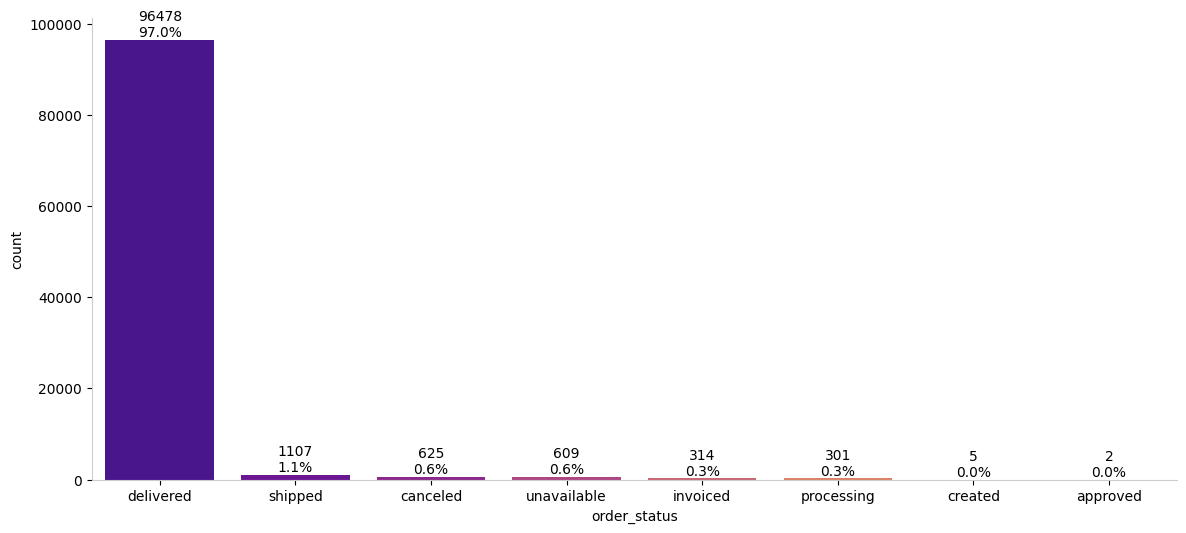

In [19]:
df_orders = orders_df.merge(customers_df, how='left', on='customer_id')
fig, ax = plt.subplots(figsize=(14, 6))
single_countplot(df_orders, x='order_status', ax=ax)
plt.show()

In [20]:
# Changing the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
# Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes for purchase date - Day and Day of Week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,zip_code,...,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,2018,7,Jul,201807,20180724,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,2017,11,Nov,201711,20171118,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,2018,2,Feb,201802,20180213,13,1,Tue,21,Night


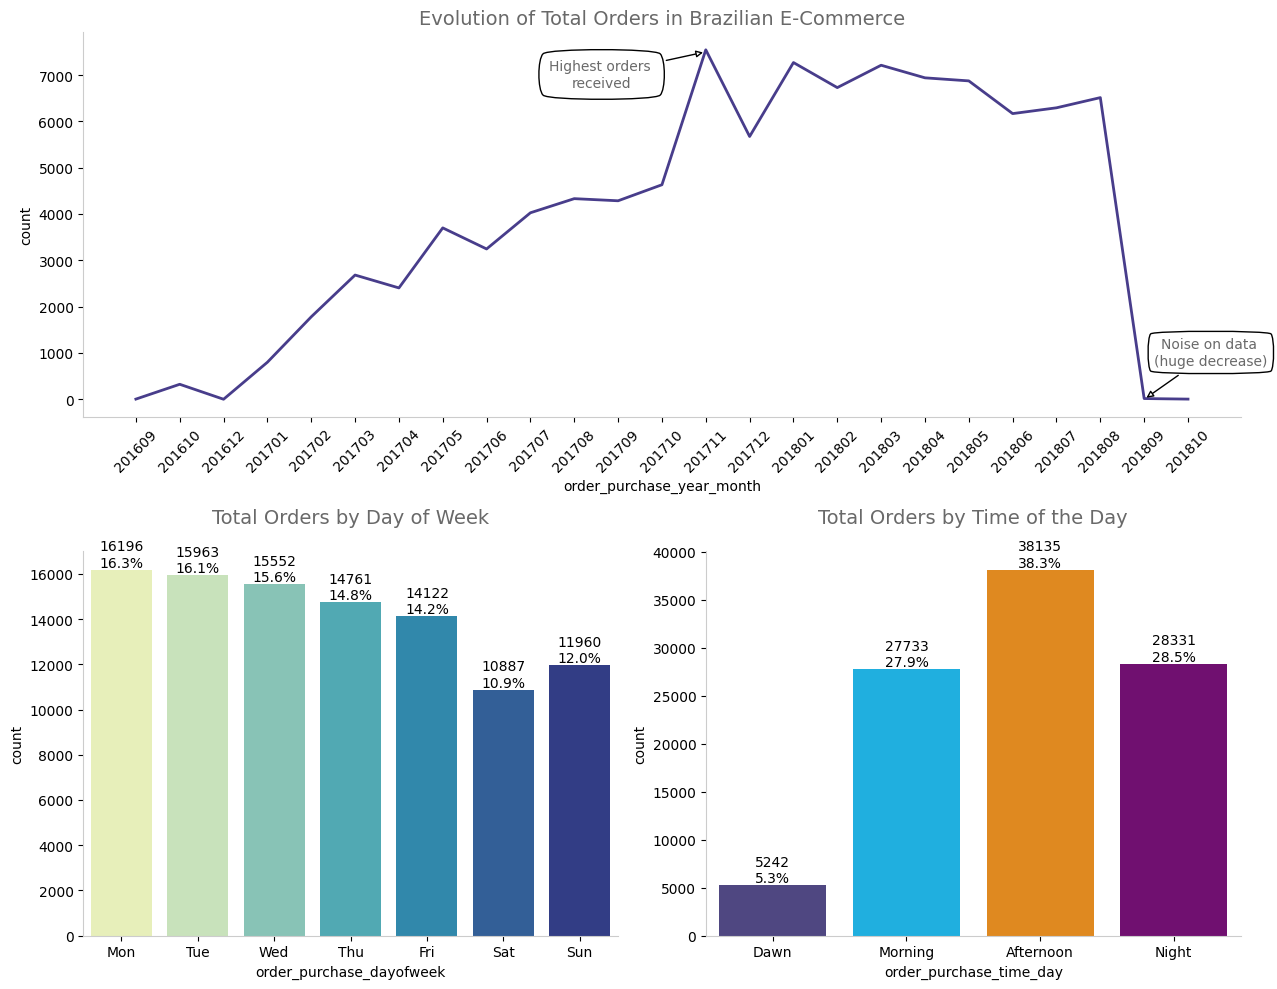

In [21]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=df_orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)
ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Noise on data \n(huge decrease)', (23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
format_spines(ax1, right_border=False)  
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')

# Barchart - Total of orders by day of week
single_countplot(df_orders, x='order_purchase_dayofweek', ax=ax2, order=False, palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orders by Day of Week', size=14, color='dimgrey', pad=20)

# Barchart - Total of orders by time of the day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
single_countplot(df_orders, x='order_purchase_time_day', ax=ax3, order=False, palette=day_color_list)
ax3.set_title('Total Orders by Time of the Day', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

By the chart above we can conclude:

* E-commerce on Brazil really has a growing trend along the time. We can see some seasonality with peaks at specific months, but in general we can see clear that customers are more prone to buy things online than before.
* Monday are the prefered day for brazilian's customers and they tend to buy more at afternoons.

_Obs: we have a sharp decrease between August 2018 and September 2018 and maybe the origin of that is related to noise on data. For further comparison between 2017 and 2018, let's just consider orders between January and August in both years_

___
* _E-commerce: a comparison between 2017 and 2018_
___

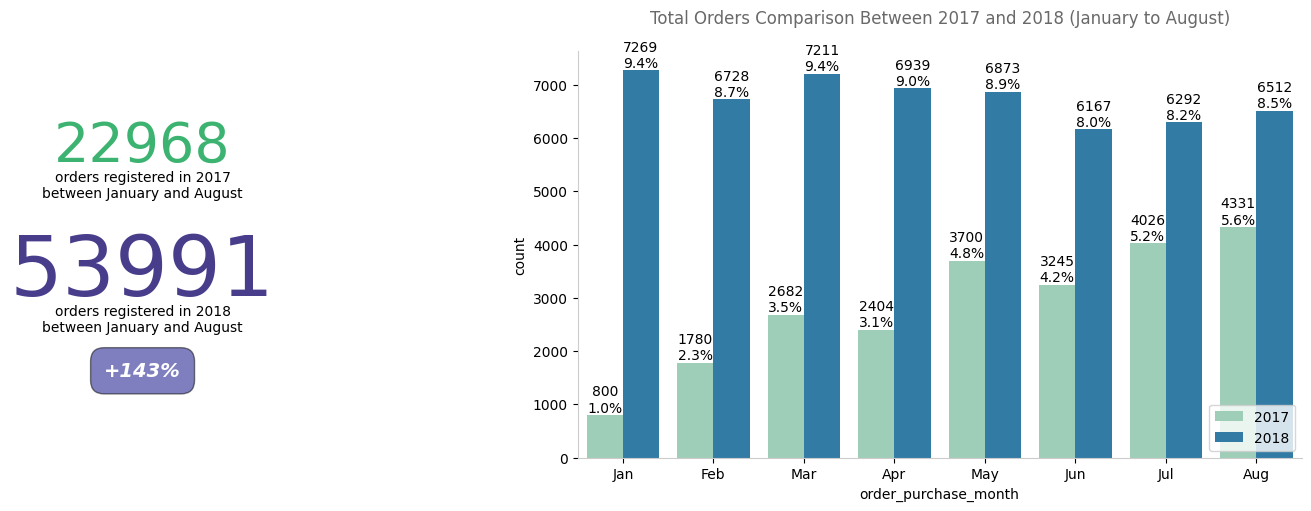

In [22]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(13, 5))

# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Annotation - Grown on e-commerce orders between 2017 and 2018
df_orders_compare = df_orders.query('order_purchase_year in (2017, 2018) & order_purchase_month <= 8')
year_orders = df_orders_compare['order_purchase_year'].value_counts()
growth = int(round(100 * (1 + year_orders[2017] / year_orders[2018]), 0))
ax1.text(0.00, 0.73, f'{year_orders[2017]}', fontsize=40, color='mediumseagreen', ha='center')
ax1.text(0.00, 0.64, 'orders registered in 2017\nbetween January and August', fontsize=10, ha='center')
ax1.text(0.00, 0.40, f'{year_orders[2018]}', fontsize=60, color='darkslateblue', ha='center')
ax1.text(0.00, 0.31, 'orders registered in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax1.text(0.00, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax1.axis('off')

# Bar chart - Comparison between monthly sales between 2017 and 2018
single_countplot(df_orders_compare, x='order_purchase_month', hue='order_purchase_year', ax=ax2, order=False,
                 palette='YlGnBu')
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
ax2.set_xticklabels(month_label)
ax2.set_title('Total Orders Comparison Between 2017 and 2018 (January to August)', size=12, color='dimgrey', pad=20)
plt.legend(loc='lower right')
plt.show()

## E-commerce around Brazil

For preparing the data to a workaround analysis on brazilian's states e-commerce, we will take the following steps:

    1. Merge the orders data to order_items data;
    2. Use an API (brazilian government) to return the region of each customer_state;
    3. Purpose useful charts to answear business questions.

In [23]:
import requests
import json

In [24]:
# Merging orders and order_items
df_orders_items = df_orders.merge(orderitem_df, how='left', on='order_id')

In [25]:
# Using the API to bring the region to the data
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
content = [c['UF'] for c in json.loads(r.text)]
br_info = pd.DataFrame(content)
br_info['nome_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis=1, inplace=True)
br_info.drop_duplicates(inplace=True)

# Threting geolocations outside brazilian map

#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo_prep = geo_df[geo_df.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng <=  -34.79314722]
geo_group = geo_prep.groupby(by='zip_code', as_index=False).min()

# Merging all the informations
df_orders_items = df_orders_items.merge(br_info, how='left', left_on='customer_state', right_on='sigla')
df_orders_items = df_orders_items.merge(geo_group, how='left', left_on='zip_code', 
                                        right_on='zip_code')
df_orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,zip_code,...,price,freight_value,id,sigla,nome,nome_regiao,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,29.99,8.72,35,SP,São Paulo,Sudeste,-23.583885,-46.587473,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,118.70,22.76,29,BA,Bahia,Nordeste,-12.945892,-45.016313,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,159.90,19.22,52,GO,Goiás,Centro-Oeste,-16.752735,-48.522139,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,45.00,27.20,24,RN,Rio Grande do Norte,Nordeste,-5.778488,-35.281450,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,19.90,8.72,35,SP,São Paulo,Sudeste,-23.760018,-46.524784,santo andre,SP


In [26]:
# Filtering data between 201701 and 201808
df_orders_filt =  df_orders_items[(df_orders_items['order_purchase_year_month'].astype(int) >= 201701)]
df_orders_filt = df_orders_filt[(df_orders_filt['order_purchase_year_month'].astype(int) <= 201808)]

# Grouping data by region
df_regions_group = df_orders_filt.groupby(by=['order_purchase_year_month', 'nome_regiao'], as_index=False)
df_regions_group = df_regions_group.agg({'customer_id': 'count', 'price': 'sum'}).sort_values(by='order_purchase_year_month')
df_regions_group.columns = ['month', 'region', 'order_count', 'order_amount']
df_regions_group.reset_index(drop=True, inplace=True)

# Grouping data by city (top 10)
df_cities_group = df_orders_filt.groupby(by='geolocation_city', 
                                       as_index=False).count().loc[:, ['geolocation_city', 'order_id']]
df_cities_group = df_cities_group.sort_values(by='order_id', ascending=False).reset_index(drop=True)
df_cities_group = df_cities_group.iloc[:10, :]

In [27]:
# Grouping data
df_month_aggreg = df_orders_filt.groupby(by=['order_purchase_year', 'order_purchase_year_month'], as_index=False)
df_month_aggreg = df_month_aggreg.agg({
    'order_id': 'count',
    'price': 'sum',
    'freight_value': 'sum'
})

# Adding new columns for analysis
df_month_aggreg['price_per_order'] = df_month_aggreg['price'] / df_month_aggreg['order_id']
df_month_aggreg['freight_per_order'] = df_month_aggreg['freight_value'] / df_month_aggreg['order_id']
df_month_aggreg.head()

,order_purchase_year,order_purchase_year_month,order_id,price,freight_value,price_per_order,freight_per_order
0,2017,201701,966,120312.87,16875.62,124.547484,17.469586
1,2017,201702,1998,247303.02,38977.60,123.775285,19.508308
2,2017,201703,3041,374344.30,57704.29,123.099079,18.975432
3,2017,201704,2697,359927.23,52495.01,133.454664,19.464223
4,2017,201705,4176,506071.14,80119.81,121.185618,19.185778


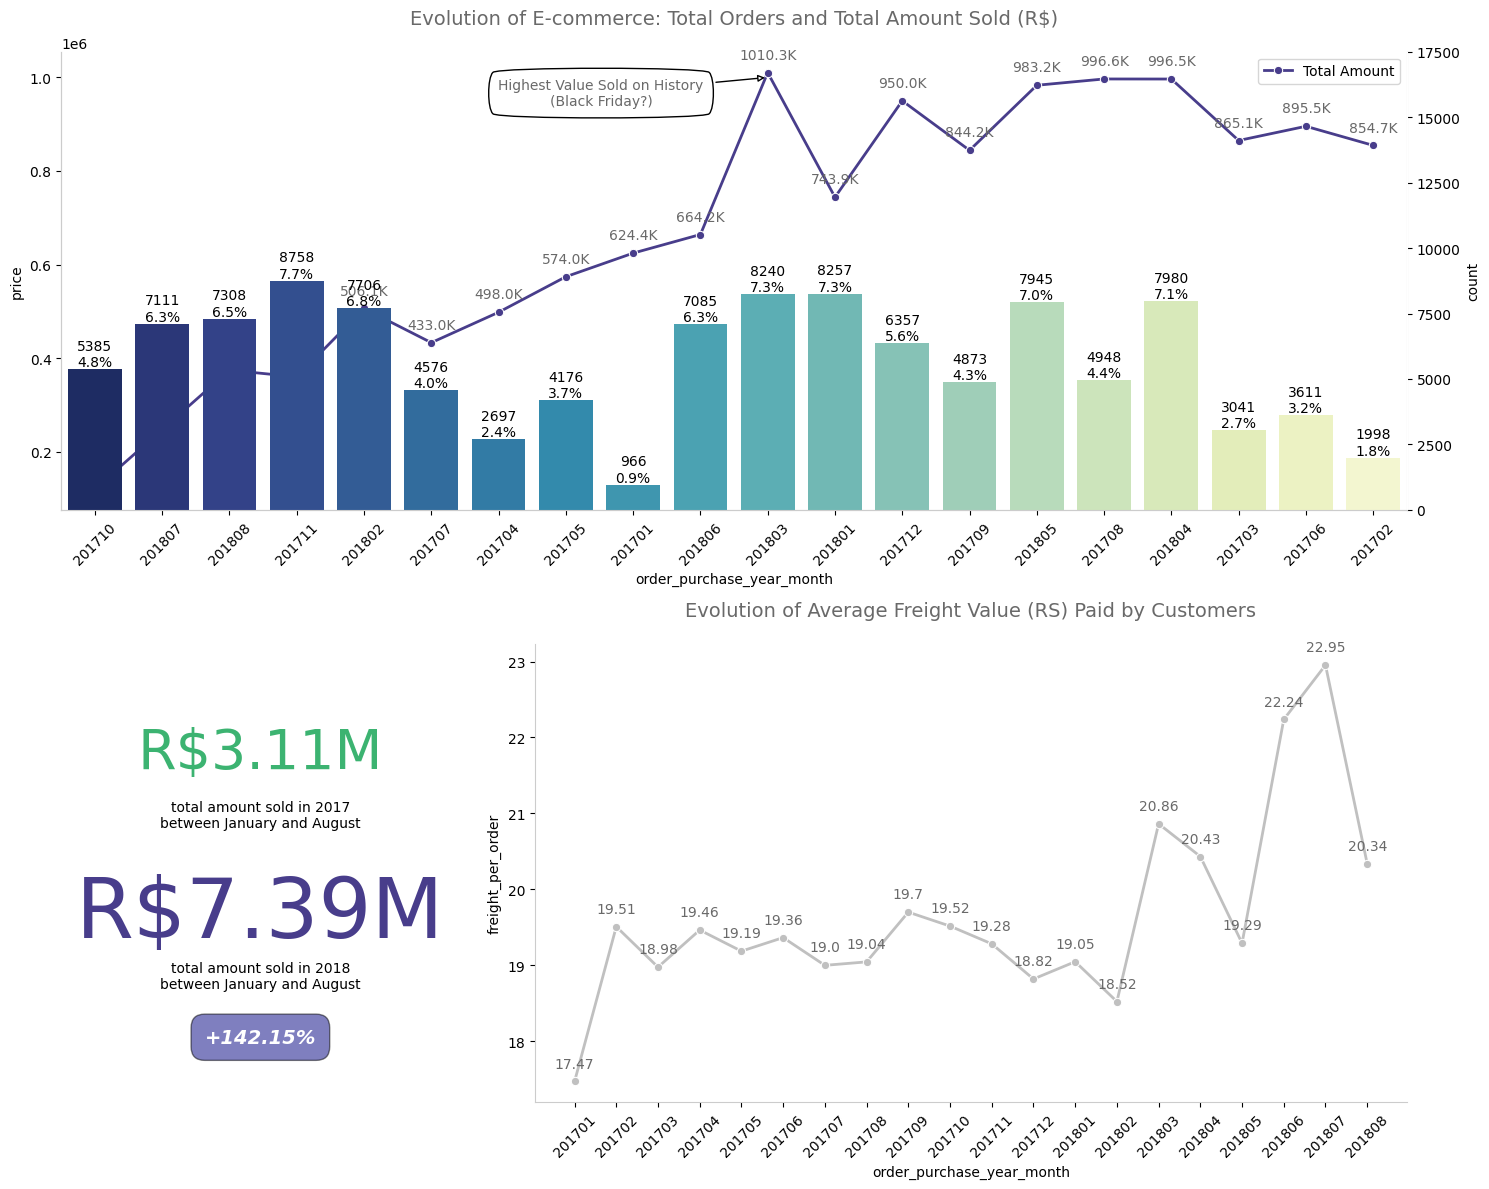

In [28]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1:])

# Plot 1 - Evolution of total orders and total sales on e-commerce
sns.lineplot(x='order_purchase_year_month', y='price', ax=ax1, data=df_month_aggreg, linewidth=2, 
             color='darkslateblue', marker='o', label='Total Amount')
ax1_twx = ax1.twinx()
single_countplot(df_orders_filt, x='order_purchase_year_month', ax=ax1_twx, order=False, palette='YlGnBu_r')
ax1_twx.set_yticks(np.arange(0, 20000, 2500))

# Customizing the first plot
format_spines(ax1)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.price.items():
    ax1.annotate(str(round(y/1000, 1))+'K', xy=(x, y), textcoords='offset points', xytext=(0, 10),
                ha='center', color='dimgrey')
ax1.annotate(f'Highest Value Sold on History\n(Black Friday?)', (10, 1000000), xytext=(-120, -20), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.set_title('Evolution of E-commerce: Total Orders and Total Amount Sold (R$)', size=14, color='dimgrey', pad=20)

# Plot 2 - Big Numbers of Sales Evolution
month_comparison = ['201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708',
                    '201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808']
df_sales_compare = df_month_aggreg.query('order_purchase_year_month in (@month_comparison)')
sold_2017 = df_sales_compare.query('order_purchase_year == 2017')['price'].sum()
sold_2018 = df_sales_compare.query('order_purchase_year == 2018')['price'].sum()
growth = 1 + (sold_2017 / sold_2018)
ax2.text(0.50, 0.73, 'R$' + str(round(sold_2017/1000000, 2)) + 'M', fontsize=40, color='mediumseagreen', ha='center')
ax2.text(0.50, 0.60, 'total amount sold in 2017\nbetween January and August', fontsize=10, ha='center')
ax2.text(0.50, 0.36, 'R$' + str(round(sold_2018/1000000, 2)) + 'M', fontsize=60, color='darkslateblue', ha='center')
ax2.text(0.50, 0.25, 'total amount sold in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax2.text(0.50, 0.13, f'{signal}{str(round(100 * growth, 2))}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax2.axis('off')

# Plot 3 - Evolution of mean freight value paid by the customers
sns.lineplot(x='order_purchase_year_month', y='freight_per_order', data=df_month_aggreg, linewidth=2, 
             color='silver', marker='o', ax=ax3)
format_spines(ax3, right_border=False)
for tick in ax3.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.freight_per_order.items():
    ax3.annotate(round(y, 2), xy=(x, y), textcoords='offset points', xytext=(0, 10),
                ha='center', color='dimgrey')
ax3.set_title('Evolution of Average Freight Value (RS) Paid by Customers', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

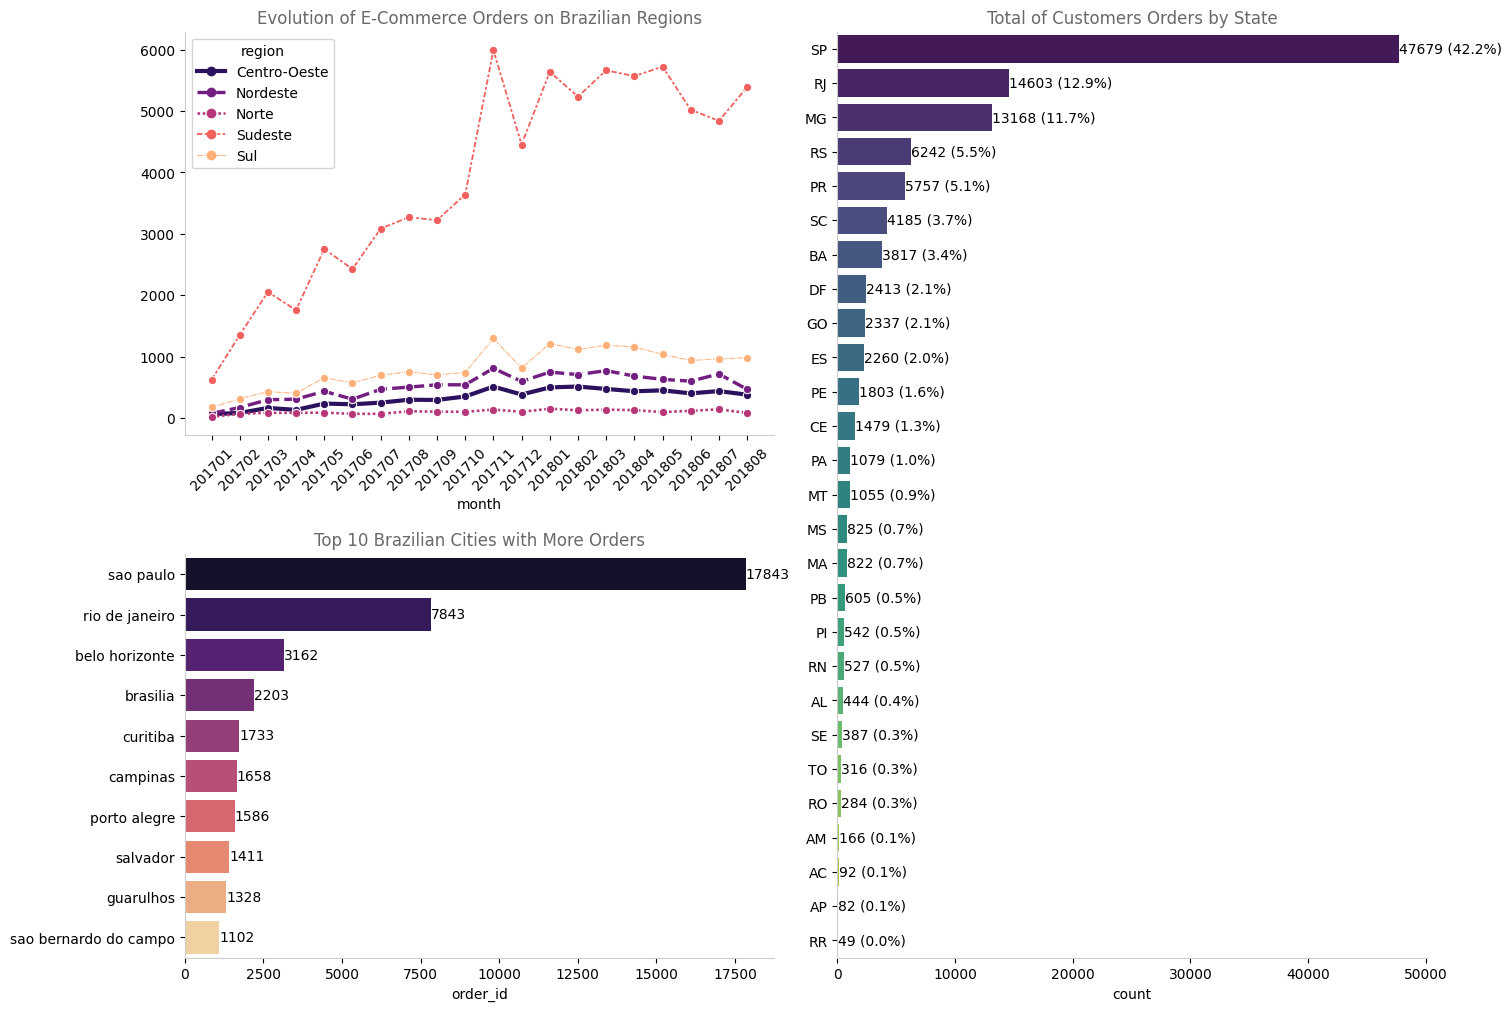

In [29]:
# Creating and preparing figure and axis
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

# Count of orders by region
sns.lineplot(x='month', y='order_count', ax=ax1, data=df_regions_group, hue='region', 
             size='region', style='region', palette='magma', markers=['o'] * 5)
format_spines(ax1, right_border=False)
ax1.set_title('Evolution of E-Commerce Orders on Brazilian Regions', size=12, color='dimgrey')
ax1.set_ylabel('')
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

# Top cities with more customers orders in Brazil
sns.barplot(y='geolocation_city', x='order_id', data=df_cities_group, ax=ax2, palette='magma')
AnnotateBars(n_dec=0, font_size=10, color='black').horizontal(ax2)
format_spines(ax2, right_border=False)
ax2.set_title('Top 10 Brazilian Cities with More Orders', size=12, color='dimgrey')
ax2.set_ylabel('')

# Total orders by state
single_countplot(y='customer_state', ax=ax3, df=df_orders_filt, palette='viridis')
ax3.set_title('Total of Customers Orders by State', size=12, color='dimgrey')
ax3.set_ylabel('')

plt.show()

In [30]:
# Zipping locations
lats = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lat'].dropna().values)[:30000]
longs = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lng'].dropna().values)[:30000]
locations = list(zip(lats, longs))

# Creating a mapa using folium
map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1

In [31]:
# En fait on ressort les dashboard client.

<a id="4.3"></a>
<font color="dimgrey" size=+2.0><b>4.3 SQL Queries</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:dimgrey" data-toggle="popover">go to TOC</a>

#### Example queries to solve the dashboard emergency.

##### Q1 - En excluant les commandes annulées, quelles sont les commandes récentes de moins de 3 mois que les clients ont reçues avec au moins 3 jours de retard ?

In [32]:
query_1 = "WITH latest_order as( \
select max(order_purchase_timestamp) \
from orders \
) \
SELECT *, JULIANDAY(order_delivered_customer_date) - \
JULIANDAY(order_estimated_delivery_date) as delta \
FROM orders \
WHERE order_purchase_timestamp >= DATE((SELECT * from latest_order), \
'-3 months') \
AND delta >= 3 \
AND order_status <> 'canceled'"

In [33]:
df_1 = pd.read_sql(query_1,cnx)

In [34]:
df_1

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delta
0,561,cfa4fa27b417971e86d8127cb688712f,7093250e1741ebbed41f0cc552025fd6,delivered,2018-08-16 09:44:23,2018-08-17 03:10:22,2018-08-17 18:55:00,2018-08-29 01:41:41,2018-08-22 00:00:00,7.070613
1,711,234c056c50619f48da64f731c48242b4,44e460a655f7154ccd9faa4dbbbaf68a,delivered,2018-08-14 14:49:15,2018-08-15 03:15:15,2018-08-31 15:25:00,2018-09-01 18:14:42,2018-08-23 00:00:00,9.760208
2,728,8ad3f1d0f96992e43566c4c82c9f6c58,948b29e24216a05fea13a18d8db45ea5,delivered,2018-07-17 21:25:29,2018-07-17 21:35:17,2018-07-18 13:08:00,2018-08-14 04:04:40,2018-08-03 00:00:00,11.169907
3,1844,7f579e203c931f3e8410103359c6d523,d665be250d1c687c58fdea61a9b55a58,delivered,2018-08-02 18:09:27,2018-08-02 18:43:43,2018-08-10 14:15:00,2018-08-13 20:11:47,2018-08-09 00:00:00,4.841516
4,1967,cb6e441ff2ef574ce08d3709426f88ec,4fb843d304c57182d4aa27bb39ca592b,delivered,2018-08-08 19:27:03,2018-08-08 19:44:59,2018-08-10 13:32:00,2018-08-18 01:11:58,2018-08-15 00:00:00,3.049977
...,...,...,...,...,...,...,...,...,...,...
317,98368,874a7690bc049bd4ce210d195bdfff7b,f6b2c83ea477af36f44a1e2df7320036,delivered,2018-08-02 12:06:47,2018-08-02 13:05:56,2018-08-10 14:42:00,2018-08-13 15:50:48,2018-08-08 00:00:00,5.660278
318,98382,587e32dd528769d669d539531d32aeb5,0af8a25fb0b6f833724bb5818275807b,delivered,2018-08-10 11:46:09,2018-08-11 02:50:25,2018-08-14 10:09:00,2018-09-03 09:32:31,2018-08-28 00:00:00,6.397581
319,98564,3adb141ba4bd69dd7fe8d3fb733c6b74,c0539d5c87fc7c97a8418adffe4b45f0,delivered,2018-08-14 23:29:21,2018-08-16 03:05:11,2018-08-16 13:28:00,2018-08-28 18:02:52,2018-08-24 00:00:00,4.751991
320,99279,4cf09d9e5ebbe0f91ddd7bf9aae891cd,07b6b4fe5fefb948fc76b6d2bdba77d8,delivered,2018-07-19 08:37:26,2018-07-21 03:25:17,2018-07-23 15:31:00,2018-08-21 01:12:45,2018-08-10 00:00:00,11.050521


##### Q2 - Qui sont les vendeurs ayant généré un chiffre d'affaires de plus de 100 000 Real sur des commandes livrées via Olist ?

In [35]:
query_2 = "WITH orders_joined as (\
SELECT distinct i.seller_id,\
i.order_id,\
i.price,\
o.order_purchase_timestamp \
from order_items as i \
INNER JOIN orders as o \
on o.order_id = i.order_id \
where o.order_status = 'delivered' \
order by seller_id, order_purchase_timestamp \
), \
aggregation as ( \
SELECT seller_id, sum(price) as total_amount_sold, \
count(order_id) as total_items_sold \
FROM orders_joined \
group by seller_id \
) \
select * from aggregation \
where total_amount_sold > 100000 \
order by total_amount_sold desc"

In [36]:
df_2 = pd.read_sql(query_2,cnx)

In [37]:
df_2

,seller_id,total_amount_sold,total_items_sold
0,4869f7a5dfa277a7dca6462dcf3b52b2,224921.54,1135
1,53243585a1d6dc2643021fd1853d8905,203364.00,348
2,fa1c13f2614d7b5c4749cbc52fecda94,190917.14,579
3,4a3ca9315b744ce9f8e9374361493884,183828.07,1810
4,7e93a43ef30c4f03f38b393420bc753a,165822.49,321
5,da8622b14eb17ae2831f4ac5b9dab84a,141875.38,1371
6,7c67e1448b00f6e969d365cea6b010ab,140998.62,995
7,7a67c85e85bb2ce8582c35f2203ad736,139098.77,1147
8,46dc3b2cc0980fb8ec44634e21d2718e,120671.54,504
9,6560211a19b47992c3666cc44a7e94c0,116660.83,1905


##### Q3 - Qui sont les nouveaux vendeurs (moins de 3 mois d'ancienneté) qui sont déjà très engagés avec la plateforme (ayant déjà vendu plus de 30 produits) ?

In [38]:
query_3 =  " WITH latest_order as( \
select max(order_purchase_timestamp) \
from orders \
), \
orders_joined as ( \
SELECT distinct i.seller_id, i.order_id, i.price, \
o.order_purchase_timestamp \
from order_items as i \
INNER JOIN orders as o \
on o.order_id = i.order_id \
where o.order_status = 'delivered' \
order by seller_id, order_purchase_timestamp \
), \
aggregation as ( \
SELECT seller_id, sum(price) as total_amount_sold, \
count(order_id) as total_items_sold \
FROM orders_joined \
group by seller_id \
having min(order_purchase_timestamp) > DATE((SELECT * from \
latest_order), '-3 months') \
) \
select * from aggregation \
where total_items_sold > 30"

In [39]:
df_3 = pd.read_sql(query_3, cnx)

In [40]:
df_3

,seller_id,total_amount_sold,total_items_sold
0,240b9776d844d37535668549a396af32,13332.09,35
1,81f89e42267213cb94da7ddc301651da,3522.00,46
2,d13e50eaa47b4cbe9eb81465865d8cfc,6987.15,67


##### Q4 - Quels sont les 5 codes postaux, enregistrant plus de 30 reviews, avec la pire review score moyen sur les 12 derniers mois ?

In [41]:
query_4 = " WITH latest_order as( \
select max(order_purchase_timestamp) \
from orders \
), \
join_orders_geoloc as ( \
SELECT distinct o.order_id, o.order_purchase_timestamp, \
c.customer_zip_code_prefix \
    FROM orders as o \
INNER JOIN customers as c \
ON o.customer_id = c.customer_id \
), \
average_review_score_per_zip as ( \
SELECT customer_zip_code_prefix, \
AVG(review_score) as avg_review_score, \
COUNT(review_score) as nb_reviews \
FROM order_reviews as r \
INNER JOIN join_orders_geoloc as o \
on r.order_id = o.order_id \
WHERE order_purchase_timestamp >= DATE((SELECT * from \
latest_order), '-12 months') \
GROUP BY customer_zip_code_prefix \
) \
SELECT * From average_review_score_per_zip \
where nb_reviews > 30 \
order by avg_review_score \
LIMIT 5 "

In [42]:
df_4 = pd.read_sql(query_4,cnx)

In [43]:
df_4

,customer_zip_code_prefix,avg_review_score,nb_reviews
0,22753,2.808511,47
1,22770,3.135135,37
2,22793,3.233333,90
3,21321,3.277778,36
4,22780,3.351351,37


In [44]:
# Construire les features RFM.

In [45]:
# transposer l'analyse des colonnes du notebook essais au fichier client.

In [46]:
# Analyse exploratoire rapide de chaque table et puis utilisation des outils python.

In [47]:
#Toute la partie feature engineering du notebook essais est déplacé vers le fichier client.

<a id="5"></a>
<font color="darkslateblue" size=+2.5><b>5. Features engineering</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:grey" data-toggle="popover">go to TOC</a>

In [48]:
# We repeat the data loading process and we only work with the data of interest.

In [49]:
# Chargement des données 
customers_df = pd.read_sql_query('select * from customers', cnx).drop('index',axis = 1)
geo_df = pd.read_sql_query('select * from geoloc', cnx).drop('index',axis = 1)
orderitem_df = pd.read_sql_query('select * from order_items', cnx).drop('index',axis = 1)
orderpay_df = pd.read_sql_query('select * from order_pymts', cnx).drop('index',axis = 1)
orderreviews_df = pd.read_sql_query('select * from order_reviews', cnx).drop('index',axis = 1) 
orders_df = pd.read_sql_query('select * from orders', cnx).drop('index',axis = 1) 
products_df = pd.read_sql_query('select * from products', cnx).drop('index',axis = 1) 
sellers_df = pd.read_sql_query('select * from sellers', cnx).drop('index',axis = 1) 
categname_df = pd.read_sql_query('select * from translation', cnx).drop('index',axis = 1) 
# Change cols names before merging 
customers_df.rename(columns={"customer_zip_code_prefix": "zip_code"}, inplace=True)
geo_df.rename(columns={"geolocation_zip_code_prefix": "zip_code"}, inplace=True)

In [81]:
# Aggregating data

In [51]:
# Join datasets
data = orders_df.merge(customers_df, on="customer_id").merge(orderitem_df, on="order_id").merge(products_df, on="product_id").merge(categname_df, on="product_category_name").merge(orderpay_df, on="order_id").merge(sellers_df, on="seller_id").merge(orderreviews_df, on="order_id")

<a id="5.1"></a>
<font color="dimgrey" size=+2.0><b>5.1 RFM Analysis</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:dimgrey" data-toggle="popover">go to TOC</a>

#### We are now creating RFM features in order to do client segmentation in a later stage.

Recency (R): how recently a customer has made a purchase. The idea is that more recent customers are likely to be more engaged and responsive to marketing efforts.

Frequency (F): how often a customer makes a purchase. Customers who make frequent purchases are considered more valuable and loyal to the business.

Monetary Value (M): monetary worth of a customer, based on the total amount they have spent. High-spending customers are generally seen as more valuable to a business.

Companies typically assign scores or rankings to customers based on these three factors. For each parameter, customers are segmented into groups (e.g., high, medium, low).

RFM analysis creates a 3-dimensional model that provides a comprehensive view of customer behavior. Each axis represents one of the three RFM factors, and the combination of these factors results in a unique point in the three-dimensional space.

We could specialise the strategy for each segment of customers.

For example, for "Recent High-Value, Less Frequent Customers", business can introduce special offers or bundles to incentivize additional purchases in order to grow loyalty and increase the frequency.

In [53]:
#  Recency
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
df_recency = data.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max()
df_recency.rename(columns={"order_purchase_timestamp":"LastPurchaseDate"}, inplace=True)
df_recency["LastPurchaseDate"] = df_recency["LastPurchaseDate"].dt.date
# Get recent invoice date and use it to calculate recency
recent_date = data['order_purchase_timestamp'].dt.date.max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)
df_recency.head()

,customer_unique_id,LastPurchaseDate,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,119
2,0000f46a3911fa3c0805444483337064,2017-03-10,542
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,326
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,293


In [54]:
#  Frequency
frequency_df = data.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}).reset_index()
frequency_df.rename(columns={"order_id":"Frequency"}, inplace=True)
frequency_df.head()

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [55]:
#  Monetary 
monetary_df = data.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
monetary_df.columns = ['customer_unique_id', 'Monetary']
monetary_df.head()

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


<a id="5.2"></a>
<font color="dimgrey" size=+2.0><b>5.2 Improved Features</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:dimgrey" data-toggle="popover">go to TOC</a>

#### We are adding new feature to improve the RFM analysis

In [79]:
# The average number of monthly payment installments per order for a customer.

In [57]:
# mean_payment_installments
mean_payment_installments_df = data.groupby('customer_unique_id', as_index=False)['payment_installments'].mean()
mean_payment_installments_df.columns = ['customer_unique_id', 'mean_payment_installments']
mean_payment_installments_df.head()

,customer_unique_id,mean_payment_installments
0,0000366f3b9a7992bf8c76cfdf3221e2,8.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1.0
2,0000f46a3911fa3c0805444483337064,8.0
3,0000f6ccb0745a6a4b88665a16c9f078,4.0
4,0004aac84e0df4da2b147fca70cf8255,6.0


In [80]:
# Average number of items per order

In [59]:
mean_items_order_df = data.groupby('customer_unique_id', as_index=False)['order_item_id'].mean()
mean_items_order_df.columns = ['customer_unique_id', 'mean_items_order']
mean_items_order_df.head()

,customer_unique_id,mean_items_order
0,0000366f3b9a7992bf8c76cfdf3221e2,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1.0
2,0000f46a3911fa3c0805444483337064,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,1.0
4,0004aac84e0df4da2b147fca70cf8255,1.0


In [60]:
# Average value of the score given to an order by a custome

In [61]:
# mean_rev_score
mean_rev_score_df = data.groupby('customer_unique_id', as_index=False)['review_score'].mean()
mean_rev_score_df.columns = ['customer_unique_id', 'mean_rev_score']
mean_rev_score_df.head()

,customer_unique_id,mean_rev_score
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0
2,0000f46a3911fa3c0805444483337064,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,4.0
4,0004aac84e0df4da2b147fca70cf8255,5.0


In [62]:
# merging dfs
rf_df = df_recency.merge(frequency_df, on='customer_unique_id')
rfm_df = rf_df.merge(monetary_df, on='customer_unique_id').drop(columns='LastPurchaseDate')
New_feat_df = rfm_df.merge(mean_payment_installments_df, on='customer_unique_id').merge(mean_rev_score_df, on='customer_unique_id').merge(mean_items_order_df, on='customer_unique_id')
New_feat_df.head()

,customer_unique_id,Recency,Frequency,Monetary,mean_payment_installments,mean_rev_score,mean_items_order
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,8.0,5.0,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,1.0,4.0,1.0
2,0000f46a3911fa3c0805444483337064,542,1,86.22,8.0,3.0,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,4.0,4.0,1.0
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,6.0,5.0,1.0


In [63]:
New_feat_df

,customer_unique_id,Recency,Frequency,Monetary,mean_payment_installments,mean_rev_score,mean_items_order
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,8.0,5.0,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,1.0,4.0,1.0
2,0000f46a3911fa3c0805444483337064,542,1,86.22,8.0,3.0,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,4.0,4.0,1.0
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,6.0,5.0,1.0
...,...,...,...,...,...,...,...
93391,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,4134.84,10.0,5.0,1.5
93392,fffea47cd6d3cc0a88bd621562a9d061,267,1,84.58,1.0,4.0,1.0
93393,ffff371b4d645b6ecea244b27531430a,573,1,112.46,1.0,5.0,1.0
93394,ffff5962728ec6157033ef9805bacc48,124,1,133.69,5.0,5.0,1.0


### Boxplot

In [64]:
New_feat_box = New_feat_df.copy()

In [65]:
New_feat_box = New_feat_box.set_index('customer_unique_id')

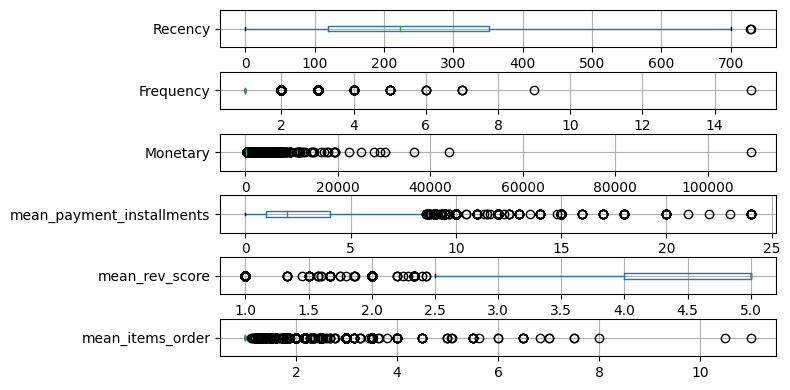

In [66]:
fig, axs = plt.subplots(len(New_feat_box.columns),1,
                        figsize=(8, 4), sharey=False)
for c, ax in zip(New_feat_box.columns, axs):
    New_feat_box.boxplot(c, vert=False, ax=ax)
fig.tight_layout(h_pad=0.051)
plt.show()

We observe a few outliers

<a id="5.3"></a>
<font color="dimgrey" size=+2.0><b>5.3 Data Transformation</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:dimgrey" data-toggle="popover">go to TOC</a>

In [67]:
# Let's check if data is skewed 
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    plt.show()
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

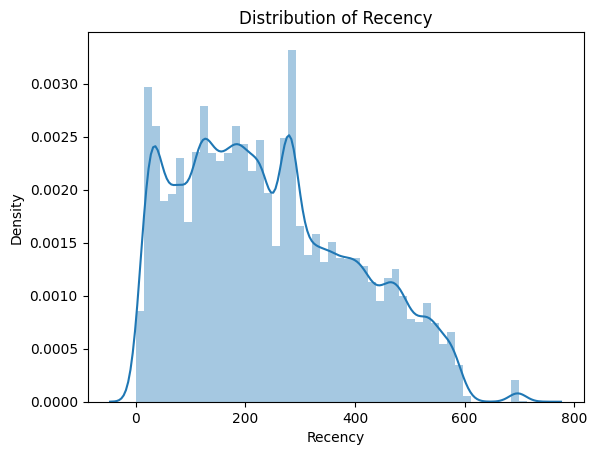

Recency's: Skew: 0.4525739019900252, : SkewtestResult(statistic=53.917503973361256, pvalue=0.0)


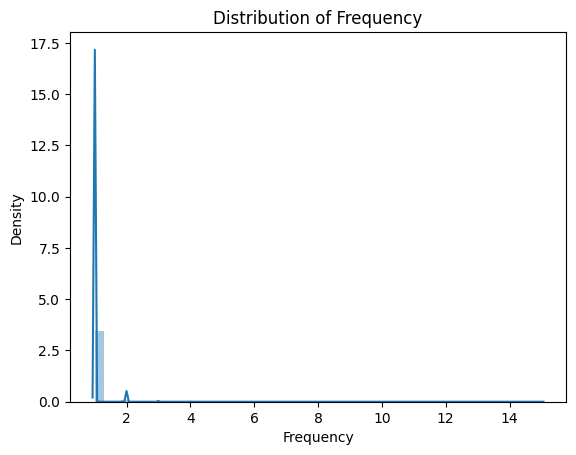

Frequency's: Skew: 10.990942154921314, : SkewtestResult(statistic=335.6456861541721, pvalue=0.0)


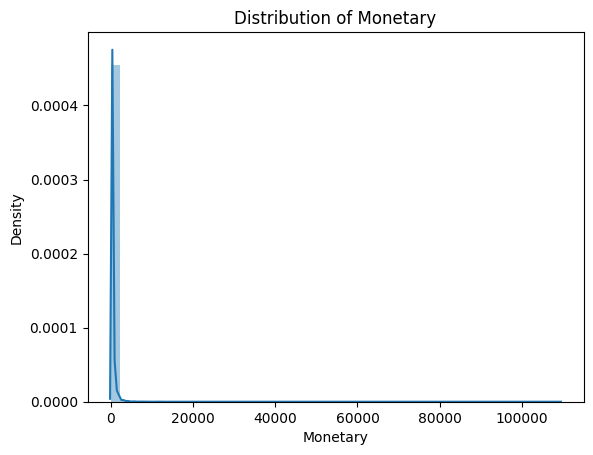

Monetary's: Skew: 70.33621193560055, : SkewtestResult(statistic=524.6379205104615, pvalue=0.0)


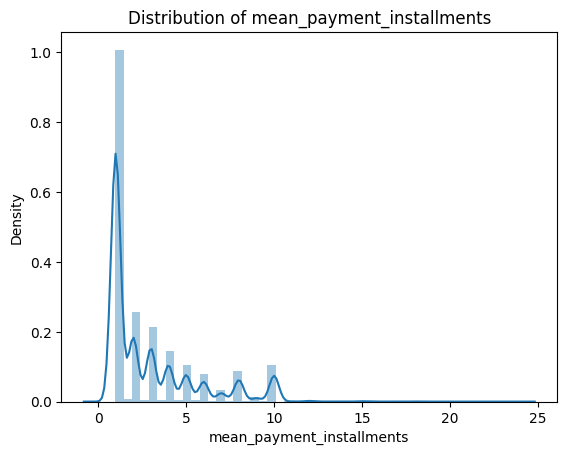

mean_payment_installments's: Skew: 1.605425910346985, : SkewtestResult(statistic=145.53164726580053, pvalue=0.0)


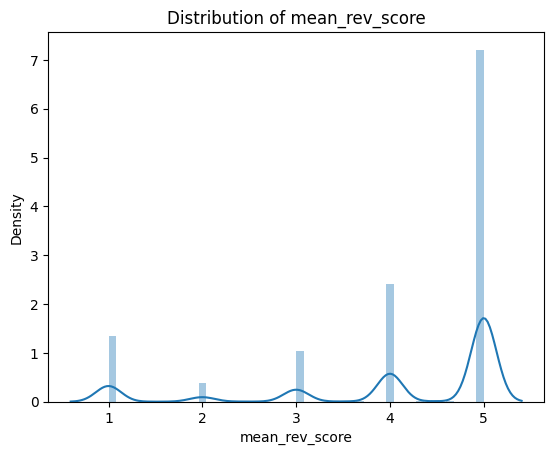

mean_rev_score's: Skew: -1.3936377857797562, : SkewtestResult(statistic=-132.88292661467767, pvalue=0.0)


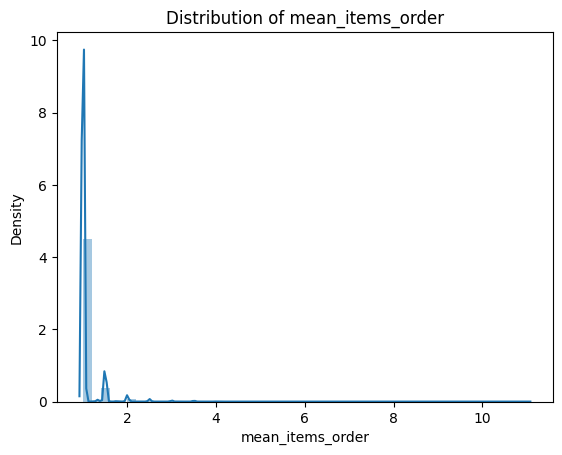

mean_items_order's: Skew: 7.326352842384715, : SkewtestResult(statistic=294.49455927256474, pvalue=0.0)


In [68]:
for col in New_feat_df.columns[1:]:
    check_skew(New_feat_df, col)

In [69]:
# Remove zeros from data before log trans
New_feat_df[New_feat_df.columns[1:]] = New_feat_df[New_feat_df.columns[1:]].map(lambda x: 1 if x ==0 else x)

In [70]:
#  log transformation 
New_feat_df_log = New_feat_df.copy()
New_feat_df_log['Monetary'] = np.log10(New_feat_df_log['Monetary'])

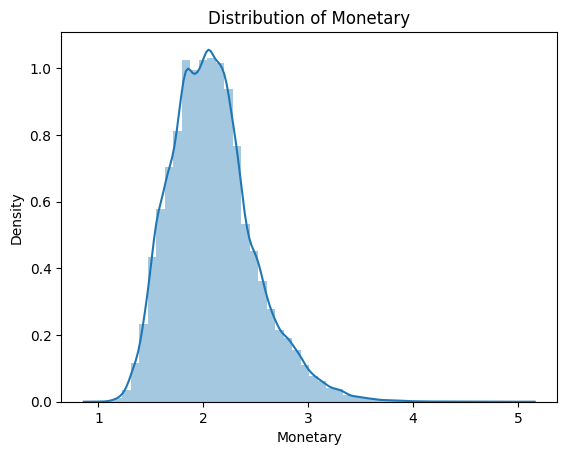

Monetary's: Skew: 0.729609897634013, : SkewtestResult(statistic=81.9204555191681, pvalue=0.0)


In [71]:
check_skew(New_feat_df_log, 'Monetary')


We now observe a normalized distribution

In [72]:
# we set customer_unique_id as an index
New_feat_df_log = New_feat_df_log.set_index('customer_unique_id')

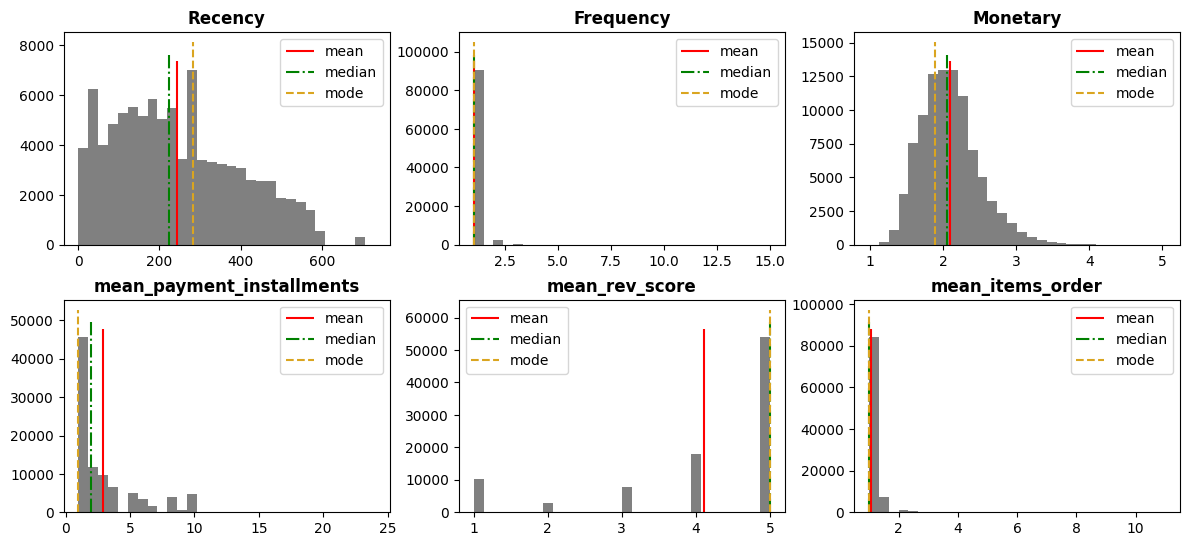

In [73]:
plot_histograms(df=New_feat_df_log, cols=New_feat_df_log.columns,
                figsize=(12,8), bins=30, layout=(3,3))

In [74]:
# Applying a standardscaler

In [75]:
New_feat = New_feat_df_log.copy()

In [76]:
# data scaling
scaler = StandardScaler()
#scaler.fit(rfm_df_log)
New_feat_scaled = pd.DataFrame(scaler.fit_transform(New_feat) , index = New_feat.index , columns=New_feat.columns)

In [77]:
#We then draw another histogram.

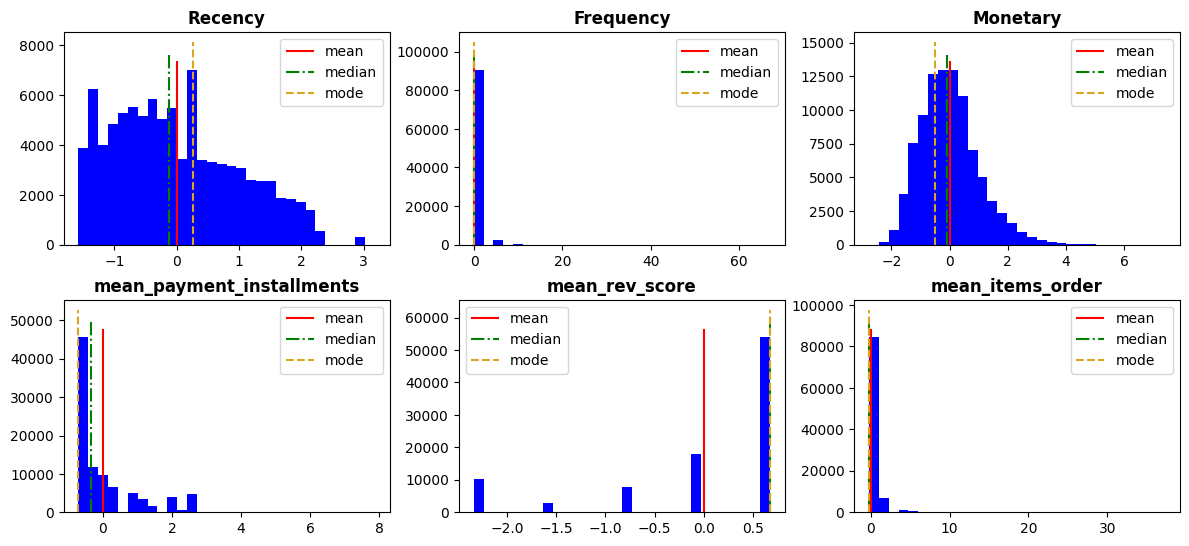

In [78]:
plot_histograms(df=New_feat_scaled, cols=New_feat_scaled.columns,color='blue',
                figsize=(12,8), bins=30, layout=(3,3))

<a id="6"></a>
<font color="darkslateblue" size=+2.5><b>6. Conclusion</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:grey" data-toggle="popover">go to TOC</a>

We were able to extract the information from the database via sqlite then by transforming this data into DataFrame format we were able to do a feature engineering of 6 features per client.


Three of these features are the RFM features: Recency, Monetary, Frequency


In addition to these features  : 

- We have a feature on customer satisfaction: mean_rev_score
- A feature on payment terms: mean_payment_installments
- And finally a feature on the nature of the purchase with the average number of items per order for a customer.



In the next step we will then use this data for customer profile clustering.